Import python modules required

In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

This function sets up the differential equations over which to integrate.
The equations are as follows:

Susceptible in Location i:
•	dSi/dt = -(sum of Susceptibles contracting illness across locations) - (sum of Infecteds coming to i and infecting Susceptibles) + (Susceptibles getting from Infecteds in I i.e. double counting)
•	dSi/dt =  - Si(0)*Pr⁡(enter m from i)×βm×InfectedmSusceptiblem - Si(0)*Pr⁡(enter m from i)×βi×InfectedmSusceptiblei +Si(0)*βi×InfectediSusceptiblei

Exposed in Location i:
•	dEi/dt = -(above) -(alpha)*(Exposed) where alpha = 1/(incubation period)

Infected in Location i:
•	dIi/dt = (alpha)*(Exposed) - (gamma)*(Infected) where gamma = 1/(infected period)

Recovered in Location i:
•	dRi/dt = (gamma)*(Infected)*(1 - mu) where mu = Case Fatality Rate

Dead in Location i:
•	dDi/dt = (gamma)*(Infected)*( mu) where mu = Case Fatality Rate


In [3]:
def deriv(y, t, beta, gamma, alpha, mu, i_move, col):
    
    su = np.ones_like(mu)-mu
    
    y_new = np.reshape(y,(int(len(y)/col),col))
    
    S = y_new[0]
    E = y_new[1]
    I = y_new[2]
    R = y_new[3]
    D = y_new[4]
    
    i_move_from_S = i_move
    i_move_to_S = np.transpose(i_move)
    Popn_home = S + E + I + R
    Popn_home_inv = 1 / Popn_home
    Popn_away = np.transpose(Popn_home)
    Popn_away_inv = 1 / Popn_away
    i_stayhome = np.diagonal(i_move)
    
    dSdt =  - S*(I*Popn_away_inv*beta).dot(i_move_from_S) \
            - S*(I*Popn_home_inv*beta).dot(i_move_to_S) \
            + S*(I*Popn_home_inv*beta*i_stayhome)
    
    dEdt =  + S*(I*Popn_away_inv*beta).dot(i_move_from_S) \
            + S*(I*Popn_home_inv*beta).dot(i_move_to_S) \
            - S*(I*Popn_home_inv*beta*i_stayhome) \
            - alpha*E
    
    dIdt =  alpha*E - gamma * I
    dRdt =  gamma * I * su
    dDdt =  gamma * I * mu

    y_new = np.array([dSdt,dEdt,dIdt,dRdt,dDdt])
    y_new = np.reshape(y_new,(1,len(dSdt)+len(dEdt)+len(dIdt)+len(dRdt)+len(dDdt)))
    y_new = np.squeeze(y_new)

    return y_new

Import the dataframe from Excel

In [4]:
wb_history = 'SEIR_Dataframe_19.04.xlsx'
xl = pd.ExcelFile(wb_history)
df_orig = xl.parse('Equations')
df_orig.fillna(0)
df_orig.head(10)

,Nr,Location,N,R,I,E,D,mu,R0,beta,...,i_wc052,i_ec444,i_kzn211,i_ec107,i_nc074,i_nc075,i_nc066,i_nc081,i_ec103,i_kzn283
0,1,jhb,6.065016e+06,47.5,415.532360,81.459218,6,0.006648,2.744501,0.196036,...,0,0,0,0,0,0,0,0,0,0
1,2,cpt,4.820346e+06,47.5,537.874669,77.069461,15,0.007907,2.005992,0.143285,...,0,0,0,0,0,0,0,0,0,0
2,3,tsh,3.964521e+06,0.0,271.621218,25.819933,0,0.007335,1.330820,0.095059,...,0,0,0,0,0,0,0,0,0,0
3,4,eth,3.832735e+06,0.0,217.074810,30.828623,20,0.007099,1.988258,0.142018,...,0,0,0,0,0,0,0,0,0,0
4,5,eku,4.056818e+06,0.0,277.944709,40.818732,0,0.006522,2.056029,0.146859,...,0,0,0,0,0,0,0,0,0,0
5,6,nma,1.318748e+06,0.0,55.600554,5.597221,4,0.008386,1.409358,0.100668,...,0,0,0,0,0,0,0,0,0,0
6,7,buf,8.089569e+05,0.0,34.106932,2.986016,0,0.008381,1.225681,0.087549,...,0,0,0,0,0,0,0,0,0,0
7,8,man,8.648638e+05,0.0,30.692711,2.438553,4,0.007663,1.112308,0.079451,...,0,0,0,0,0,0,0,0,0,0
8,9,lim354,7.765748e+05,0.0,3.416653,0.278874,1,0.007185,1.142710,0.081622,...,0,0,0,0,0,0,0,0,0,0
9,10,kzn225,6.914099e+05,0.0,39.159422,4.629498,0,0.007511,1.655106,0.118222,...,0,0,0,0,0,0,0,0,0,0


Create a copy of dataframe to edit

In [5]:
df = df_orig.copy()

Add in some of the SEIR model requirements

In [6]:
df['alpha'] = 1/df['Tinc']
df['gamma'] = 1/df['Tinf']
df['beta'] = df['R0']/df['Tinf']
df['S'] = df['N'] - df['I'] - df['R'] - df['D'] - df['E']
df.drop(['R0', 'Tinc', 'Tinf'], axis=1,inplace=True)

In [7]:
Loc = df['Location']
S0 = df['S']
E0 = df['E']
I0 = df['I']
R0 = df['R']
D0 = df['D']
beta = df['beta']
alpha = df['alpha']
gamma = df['gamma']
mu = df['mu']
i_move = df
i_move.drop(['Nr','Location','N','R','I','E','D','S','mu','alpha','beta','gamma'], axis=1,inplace=True)
i_move = i_move.to_numpy()
i_move = np.transpose(i_move)

Set the forecast days and create output space for integration function

In [8]:
Forecast_days = 365
t = np.linspace(0, Forecast_days, Forecast_days)

ODEINT can only take in a vector of data, not a matrix, so reshape data into vector

In [9]:
y0 = np.array([S0,E0,I0,R0,D0])
col = len(S0)
y0 = np.reshape(y0,(1,len(S0)+len(E0)+len(I0)+len(R0)+len(D0)))
y0 = np.squeeze(y0)
y0.shape

(1110,)

Create integration function over differential equation system

In [10]:
ret = odeint(deriv, y0, t, args=(beta, gamma, alpha, mu, i_move, col))

Plot results over time

 ...]

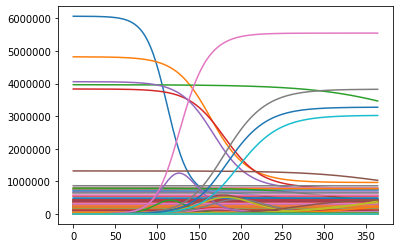

In [11]:
plt.plot(ret)

In [12]:
ret_ar = np.array(ret)
ret_ar.shape

(365, 1110)

Reshape vector into SEIRD matrix

In [13]:
col_size = int(len(ret_ar[1])/col)
S_new = ret_ar[:,0:col]
E_new = ret_ar[:,col:2*col]
I_new = ret_ar[:,2*col:3*col]
R_new = ret_ar[:,3*col:4*col]
D_new = ret_ar[:,4*col:]

Create Excel workbook in which to copy out results from model

In [14]:
from openpyxl import Workbook, load_workbook
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [15]:
wb = Workbook()
current_datestamp = datetime.strftime(datetime.today(),'%d-%m-%Y')

In [16]:
daterng = np.array([datetime.today() + relativedelta(days = i) for i in range(0,Forecast_days)])
daterng.shape

(365,)

Output results into Excel workbook and save

In [17]:
ws = wb.create_sheet("Output", 0)

j = 0
while j < 5:
    for i in range(0,len(Loc)):
        if j == 0:
            ws.cell(row = 1, column = 2+ j*len(Loc) + i).value = 'Susceptible'
        elif j == 1:
            ws.cell(row = 1, column = 2+ j*len(Loc) + i).value = 'Exposed'
        elif j == 2:
            ws.cell(row = 1, column = 2+ j*len(Loc) + i).value = 'Infected'
        elif j == 3:
            ws.cell(row = 1, column = 2+ j*len(Loc) + i).value = 'Recovered'
        elif j == 4:
            ws.cell(row = 1, column = 2+ j*len(Loc) + i).value = 'Dead'
        ws.cell(row = 2, column = 2+ j*len(Loc) + i).value = Loc[i]
    j += 1

for i in range(0,len(daterng)):
    ws.cell(row=3+i, column=1).value = daterng[i]

for i in range(0,col):
    for j in range(0, len(S_new)):
        ws.cell(row = 3 + j, column = 2 + i).value = S_new[j][i]

for i in range(0,col):
    for j in range(0, len(E_new)):
        ws.cell(row = 3 + j, column = 2 + len(Loc) + i).value = E_new[j][i]

for i in range(0,col):
    for j in range(0, len(I_new)):
        ws.cell(row = 3 + j, column = 2 + 2*len(Loc) + i).value = I_new[j][i]

for i in range(0,col):
    for j in range(0, len(R_new)):
        ws.cell(row = 3 + j, column = 2 + 3*len(Loc) + i).value = R_new[j][i]
        
for i in range(0,col):
    for j in range(0, len(D_new)):
        ws.cell(row = 3 + j, column = 2 + 4*len(Loc) + i).value = D_new[j][i]

wb.save('SEIR_' + current_datestamp + '.xlsx')